# Imports

In [22]:
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import os
import scipy.ndimage as ndimage
from astropy.wcs import WCS
import emcee

from ClusterModel.ClusterTools import map_tools
from ClusterModel import model

from getdist import plots, MCSamples

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

# Define a cluster object

In [3]:
clust = model.Cluster(name='Coma', redshift=0.023, M500=7e14*u.Msun, cosmology=cosmo, silent=True)
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

# To save outputs if requested
clust.output_dir = '/Users/adam/Desktop/test'

# We can check out the parameters
clust.print_param()

--- theta_truncation
    2.37848219885 deg
    <class 'astropy.units.quantity.Quantity'>
--- abundance
    0.3
    <type 'float'>
--- R_truncation
    4108.40464651 kpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    7e+14 solMass
    <class 'astropy.units.quantity.Quantity'>
--- map_reso
    0.02 deg
    <class 'astropy.units.quantity.Quantity'>
--- theta500
    0.792827399615 deg
    <class 'astropy.units.quantity.Quantity'>
--- Rmin
    1.0 kpc
    <class 'astropy.units.quantity.Quantity'>
--- magfield_model
    {'a': 1.33, 'c500': 1.81, 'c': 0.155, 'b': 2.065, 'name': 'GNFW', 'r_p': <Quantity 756.61227376 kpc>, 'P_0': <Quantity 10. uG>}
    <type 'dict'>
--- density_gas_model
    {'a': 1.33, 'c500': 1.81, 'c': 0.31, 'b': 4.13, 'name': 'GNFW', 'r_p': <Quantity 756.61227376 kpc>, 'P_0': <Quantity 0.00193462 1 / cm3>}
    <type 'dict'>
--- Epmin
    1.21793391659 GeV
    <class 'astropy.units.quantity.Quantity'>
--- pp_interaction_model
    Pythia8
    <type 'str'>
--- R500

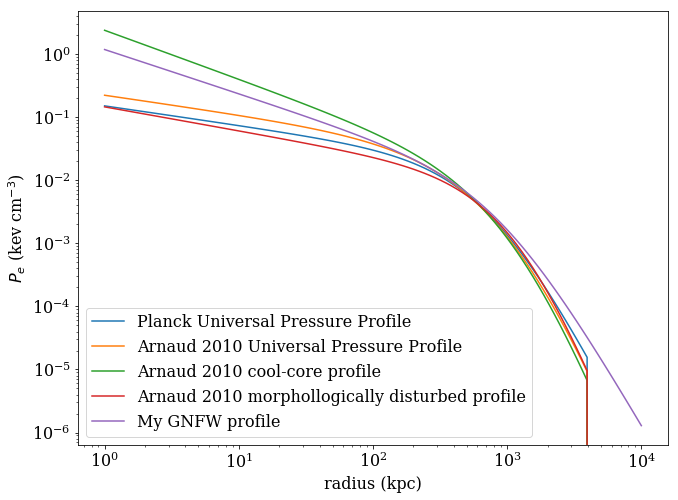

In [4]:
# How to change the pressure model

plt.figure(figsize=(10,8))

# We can use standard profiles based on mass and redshift
clust.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Planck Universal Pressure Profile')
clust.set_pressure_gas_gNFW_param('A10UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 Universal Pressure Profile')
clust.set_pressure_gas_gNFW_param('A10CC')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 cool-core profile')
clust.set_pressure_gas_gNFW_param('A10MD')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Arnaud 2010 morphollogically disturbed profile')

# Note that we can redefine the truncation, e.g., no truncation, and define our own profile
clust.R_truncation = np.inf*u.kpc
clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='My GNFW profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$P_e$ (kev cm$^{-3}$)')
plt.legend()

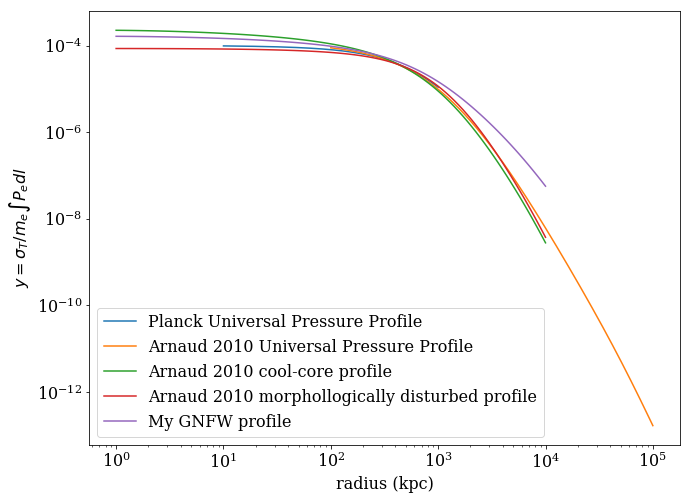

In [8]:
# How to derive the Compton parameter profile

plt.figure(figsize=(10,8))

clust.set_pressure_gas_gNFW_param('P13UPP')
# Note that we can pass a user defined radius
radius = np.logspace(1,3,1000)*u.kpc 
r, y_r = clust.get_sz_profile(radius, Compton_only=True)
plt.loglog(r, y_r, label='Planck Universal Pressure Profile')

# by default, the line of sight integration stops at 5R500, but we can change that
clust.set_pressure_gas_gNFW_param('A10UPP')
r, y_r = clust.get_sz_profile(np.logspace(2,5,1000)*u.kpc, NR500_los=30.0, Compton_only=True)
plt.loglog(r, y_r, label='Arnaud 2010 Universal Pressure Profile')

clust.set_pressure_gas_gNFW_param('A10CC')
r, y_r = clust.get_sz_profile(Compton_only=True)
plt.loglog(r, y_r, label='Arnaud 2010 cool-core profile')

clust.set_pressure_gas_gNFW_param('A10MD')
r, y_r = clust.get_sz_profile(Compton_only=True)
plt.loglog(r, y_r, label='Arnaud 2010 morphollogically disturbed profile')

clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}
r, y_r = clust.get_sz_profile(Compton_only=True)
plt.loglog(r, y_r, label='My GNFW profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$y = \\sigma_T/m_e \int P_e dl$')
plt.legend()

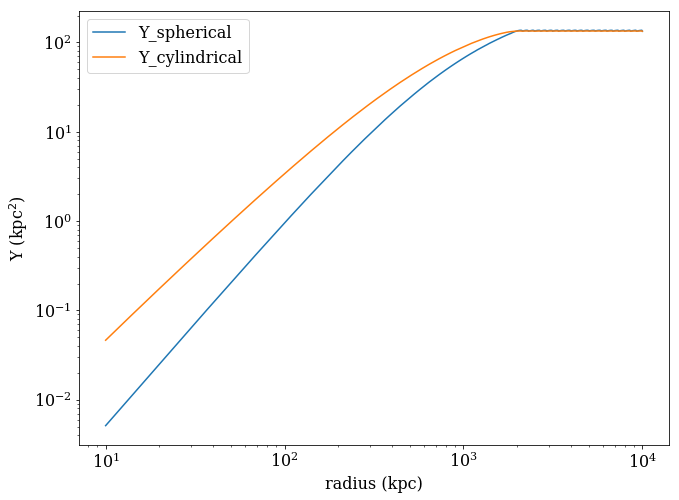

In [16]:
# How to derive the integrated profiles

clust.R_truncation = 2000*u.kpc
clust.pressure_gas_model = {'name':'GNFW', 'P_0':1e-2*u.keV/u.cm**3, 'c500':1.5, 'a':1.3, 'b':3.7, 'c':0.7}

plt.figure(figsize=(10,8))
radius = np.logspace(1,4,1000)*u.kpc 
# either the spherically integrated SZ flux
y_r = clust.get_sz_flux(Rmax=radius, Compton_only=True, type_integral='spherical')
plt.loglog(radius, y_r, label='Y_spherical')

# or the cylindrically integrated
y_r = clust.get_sz_flux(Rmax=radius, Compton_only=True, type_integral='cylindrical')
plt.loglog(radius, y_r, label='Y_cylindrical')

plt.xlabel('radius (kpc)')
plt.ylabel('Y (kpc$^2$)')
plt.legend()

# Note that because of truncation, the Y profile remain constant beyond R_truncation
# At r = infinity, the sphercial and cylindrical profile should converge

# Extract the Compton parameter map from Planck

In [26]:
# Lets first define the directory where we have put the Planck y_map
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file  = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'

# We can play with the map size and resolution of our map
clust.map_fov = 6*u.deg
clust.map_reso = 1*u.arcmin
reso_out = clust.map_reso.to_value('deg')

ymap, header = map_tools.roi_extract_healpix(ymap_file, clust.coord.ra.value, clust.coord.dec.value, 
                                   clust.map_reso.to_value('deg'), 
                                             [clust.map_fov[0].to_value('deg'), clust.map_fov[1].to_value('deg')],
                                             visu=False)

# We can also set the header of our model to a given map (to have pixel-pixel comparison)
clust.map_header = header

Text(0.5,1,'Coma Planck map, y x $10^6$')

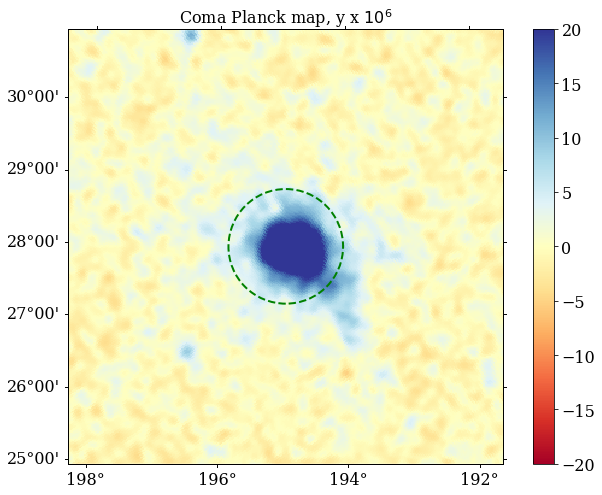

In [27]:
fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymap, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' Planck map, y x $10^6$')

# Compute a model ymap

In [30]:
# Let's get a ymap, and smooth it to the Planck Beam for comparison
ymodel = (clust.get_sz_map(Compton_only=True)).value

FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
sm = 10.0
ymodel = ndimage.gaussian_filter(ymodel, sigma=(FWHM2sigma*sm/60/reso_out, FWHM2sigma*sm/60/reso_out), order=0)

Text(0.5,1,'Coma Model map, y x $10^6$')

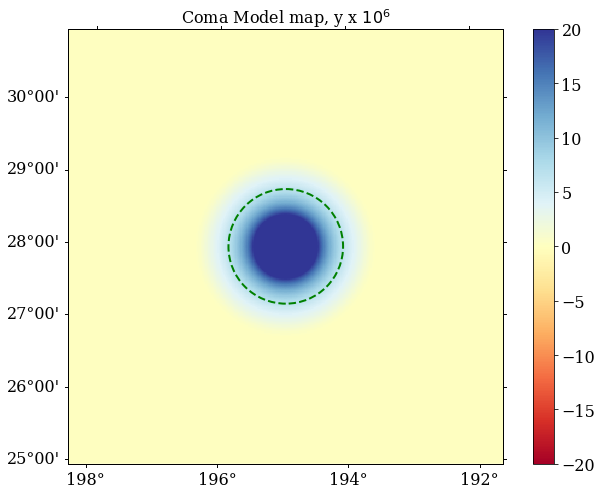

In [31]:
fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymodel, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' Model map, y x $10^6$')

Text(0.5,1,'Coma low mass model map, y x $10^6$')

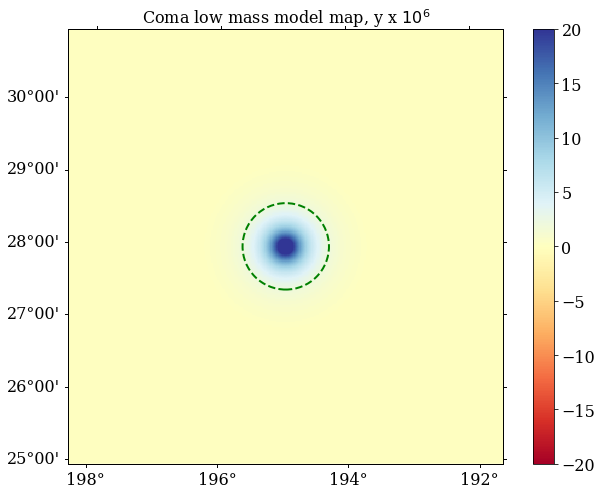

In [33]:
# Let see how the model affect the map by setting a low mass and using the UPP
clust.M500 = 3e14*u.Msun
clust.set_pressure_gas_gNFW_param('P13UPP')
ymodel = (clust.get_sz_map(Compton_only=True)).value
ymodel = ndimage.gaussian_filter(ymodel, sigma=(FWHM2sigma*sm/60/reso_out, FWHM2sigma*sm/60/reso_out), order=0)

fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*ymodel, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+' low mass model map, y x $10^6$')

# MCMC fit of the parameters (amplitude and concentraction)

In [34]:
# Defines model
def model(clust, params):
    P_0  = params[0]
    c500 = params[1]
    clust.pressure_gas_model = {'name':'GNFW', 'P_0':P_0*u.keV/u.cm**3, 'c500':c500, 'a':1.8, 'b':3.1, 'c':0.0}
    ymod = (clust.get_sz_map(Compton_only=True)).value
    ymod = ndimage.gaussian_filter(ymod, sigma=(FWHM2sigma*sm/60/reso_out, FWHM2sigma*sm/60/reso_out), order=0)
    return ymod

# Defines log likelihood
def lnlike(params, clust, data, err) :
    mod = model(clust, params)
    chi2 = ((data - mod)**2) / (err**2)
    # Put prior on parameters >0 here
    if params[0] > 0 and params[1] > 0:
        return -0.5*np.sum(chi2)
    else:
        return -np.inf

In [35]:
# Get the data, error, and initial parameters
clust.R500 = 1.31*u.Mpc # Since we fir for c500, R500 should be defined (from Planck2013 Coma paper)

data = ymap
err = ymap*0 + np.std(ymap) # First guess for errors
for i in [1,2,3,4,5,6]: err = ymap*0 + np.std(ymap[ymap/err < 5]) # Refine error, but still no covariance here
par0 = np.array([2.0e-2, 3.0]) # guess parameters

In [36]:
# Run the MCMC
ndim, nwalkers, nsteps, burnin = len(par0), 10, 2000, 500

nwalkers = 10
ndim = len(par0)
pos = [par0 + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, a=2.0, args=[clust, data, err], threads=2)
sampler.run_mcmc(pos, nsteps)

(array([[0.02199488, 2.84464182],
        [0.02210459, 2.85074299],
        [0.02199124, 2.84351793],
        [0.02198069, 2.84539008],
        [0.02203162, 2.84367504],
        [0.02218254, 2.85753638],
        [0.02202942, 2.84767418],
        [0.02214864, 2.85329267],
        [0.0219255 , 2.83771889],
        [0.02207056, 2.84873308]]),
 array([-66740.53110602, -66740.2631226 , -66740.48168268, -66741.48933421,
        -66741.48359368, -66741.00481227, -66740.64714274, -66740.50200346,
        -66741.58572631, -66740.20799712]),
 ('MT19937', array([ 810492881, 4293425902, 3390905514, 2352428763,  548822189,
         3667991040, 2483468872, 3624992496, 1540065983, 2790905634,
         3396336268, 2692636700, 1830861616, 1099931183, 1572842558,
         1283904335, 1156787942, 4259674020,  457110083, 1565758400,
         2931073391, 1924953646, 2334321545, 3060486386, 3327031948,
          264968748, 4054262238, 1922447003, 2985948498, 3228957319,
         2988994953,  748286300,  324

In [37]:
# Burn in
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

In [38]:
# Get the best fit parameters
wbest = (lnL_chains == np.amax(lnL_chains))
p0_best = ((param_chains[:,:,0])[wbest])[0]
c500_best = ((param_chains[:,:,1])[wbest])[0]

print(p0_best, c500_best)

(0.022066958250227628, 2.8486939062724925)


 ...]

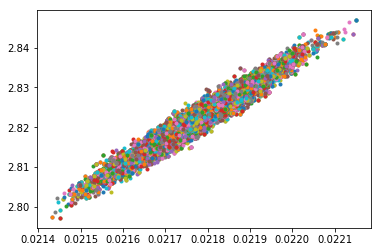

In [16]:
# Show the constraints
plt.plot(param_chains[:,:,0], param_chains[:,:,1], '.')

Removed no burn in


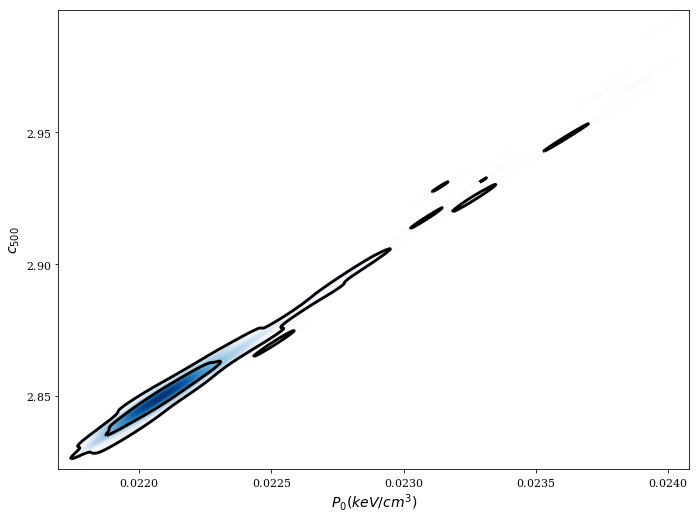

In [39]:
ch = MCSamples(samples=param_chains, label=clust.name, names=['P_0','c500'], labels=['P_0 (keV/cm^3)', 'c_{500}'])
g = plots.getSinglePlotter(width_inch=10)
g.plot_2d(ch, 'P_0', 'c500', shaded=True);

Text(0.5,1,'Coma, data - best fit model, y x $10^6$')

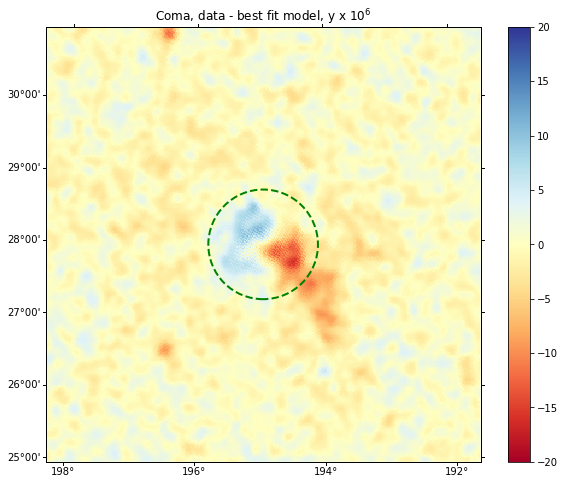

In [196]:
# Look at the residual map
ybest = model(clust, [p0_best, c500_best])

fig = plt.figure(figsize=(10, 8))
rad = clust.theta500.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(1e6*(ybest-ymap), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad/np.cos(clust.coord.dec.value*np.pi/180), 2*rad,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(clust.name+', data - best fit model, y x $10^6$')

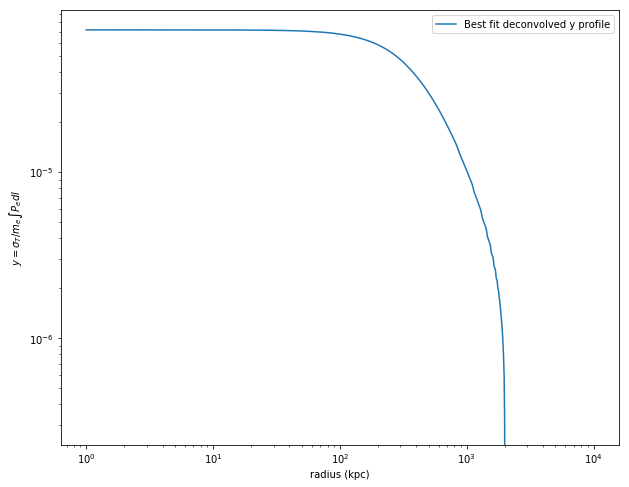

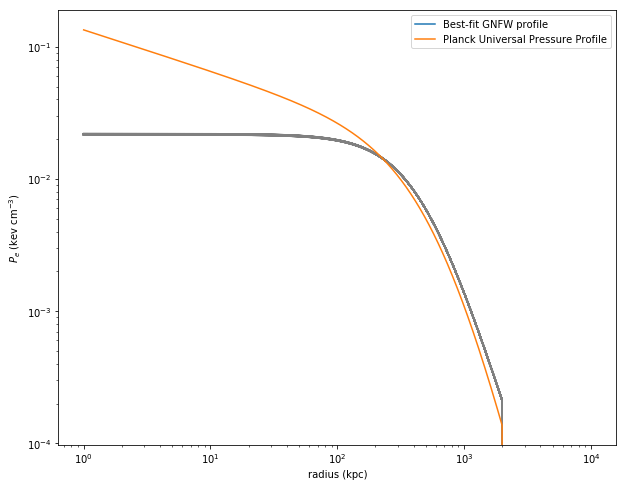

In [43]:
# How to derive the Pressure and Compton parameter profile
clust.pressure_gas_model = {'name':'GNFW', 'P_0':p0_best*u.keV/u.cm**3, 'c500':c500_best, 'a':1.8, 'b':3.1, 'c':0.0}

plt.figure(figsize=(10,8))
r, y_r = clust.get_y_compton_profile()
plt.loglog(r, y_r, label='Best fit deconvolved y profile')
plt.xlabel('radius (kpc)')
plt.ylabel('$y = \\sigma_T/m_e \int P_e dl$')
plt.legend()


plt.figure(figsize=(10,8))

r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Best-fit GNFW profile')

chains = np.reshape(param_chains, (param_chains.shape[0]*param_chains.shape[1],param_chains.shape[2]))
w = (np.linspace(0,len(chains[:,0]), 100, dtype='int'))
for i in range(99):
    clust.pressure_gas_model = {'name':'GNFW', 'P_0':chains[w[i],0]*u.keV/u.cm**3, 'c500':chains[w[i],1], 'a':1.8, 'b':3.1, 'c':0.0}
    r, p_r = clust.get_pressure_gas_profile()
    plt.loglog(r, p_r, 'grey')

clust.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = clust.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Planck Universal Pressure Profile')

plt.xlabel('radius (kpc)')
plt.ylabel('$P_e$ (kev cm$^{-3}$)')
plt.legend()